## Problem Statement: To identify language of each sentence (test instance) from the EuroPARL test dataset

In this challenge, we will try to develop a machine learning model to classify the language of a particular sentence in the EuroPARL test set provided on the fellowship.ai/challenge page. Text from 21 different European languages are present in the test set.

For the purpose of language detection, we will use a subset of EuroPARL parallel corpus version 7 for training the algorithm because it consists of text similar to the test set.

Before attempting to code, I read some research papers in language identification domain and most of the studies had used N-gram based approach. So, I also decided to try N-grams approach paired with my own version of statistical measure for language identification. It is a simple yet powerful technique to identify language of the text.

Methodology:

1. Data stage: Creating a small training and validation subset out of the large 10GB EuroPARL dataset. EuroPARL dataset was created for research in language translation domain. So, each of the 21 languagea is translated into english language.

2. Train stage: Compute top ngrams (in decreasing order of frequency) for each language and storing it in array of dictionaries(ngrams, value and rank). CountVectorizer from scikit-learn is used.

3. Predict stage: Compute all ngrams for each instance in the test set and find similariy measure(sameness) between the instance and each language and predict the language which has the maximum similarity with the instance.

4. Metrics: Compute accuracy and confusion matrix for different values of lines_per_lang, top_ngrams and ngram_range and find the best combination for accuracy and speed.

### Step 0: Import all the functions and packages required

In [1]:
import numpy as np
import string, random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

### Step 1: Create a small training and validation set from the 10GB EuroPARL dataset (in 21 languages)

In [2]:
# function to create training and validation datasets
def create_train_valid(eu_files_path, langs_arr, lines_per_lang):
    # training and validation file
    train_file = 'europarl.train'
    valid_file = 'europarl.valid' # similar to test data for training purposes
    # open training and validation file simulataneously
    with open(train_file, 'w') as wf1, open(valid_file, 'w') as wf2:
        for lang in langs_arr:
            file_name = f'{eu_files_path}{lang}-en.{lang}'   # language specific filename
            if lang == 'en':   # selecting the english filename
                file_name = f'{eu_files_path}bg-en.en'
            # open particular language file in the EuroPARL dataset and create training file and validation file by randomly selecting lines in the complete file
            with open(file_name, 'r') as rf:
                # randomly selecting lines (lines = lines_per_lang param) out of complete file
                lines = random.sample(rf.readlines(),lines_per_lang+1200)
                # writing lines to training file
                for line in lines[:-1200]:
                    wf1.write(f'{lang},{line}')
                # writing lines to validation file
                for line in lines[lines_per_lang:]:
                    # not consider lines with characters less than 20
                    if len(line) > 20:
                        wf2.write(f'{lang}\t{line}')
    print(f'{train_file} and {valid_file} file created!')

### Step 2: Preprocessing Functions: Removing Punctuation and Digits from the text

For removing digits and punctuations which are generally not useful in identifying languages.

In [3]:
# function to remove punctuation (except apostrophes) and digits from a string
def remove_punctuation_digits(s):
    # remove punctuation
    table1 = str.maketrans({key: None for key in string.punctuation if key != "'"})
    # remove digits
    table2 = str.maketrans({str(key): None for key in range(0,10)})
    return s.translate(table1).translate(table2)

### Step 3: Function to create N-gram frequency profile for a document (corpus)

In [4]:
# function to extract ngrams from text
def extract_ngrams(corpus, ngram_range=(1, 5)):
    # compute ngrams for a corpus
    cv = CountVectorizer(analyzer='char_wb', ngram_range=ngram_range)
    ngrams = cv.fit_transform(corpus)
    # ngram vocab
    vocab = cv.vocabulary_
    # frequency of each item in the vocab
    count_values = ngrams.toarray().sum(axis=0)
    return vocab, count_values

# function to sort and extract top 'N' ngrams
def extract_top_ngrams(corpus, ngram_range, N):
    # extract all ngrams
    vocab, count_values = extract_ngrams(corpus, ngram_range)
    if N == -1:         # if N = -1, we need to extract all the ngrams        
        top_ngrams = len(vocab.items()) - 1   # -1 for removing whitespace later on
    else:    
        top_ngrams = N - 1   # -1 for removing whitespace later on
    ngram_profile = dict()
    # sort ngrams in decreasing order of frequencies and limit till N
    for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
        # remove whitespace 1-gram
        if ng_text == ' ':
            continue
        # create dictionary of the ngram_profile with ngram and its rank in the document
        ngram_profile[ng_text] = top_ngrams
        top_ngrams -= 1
        if top_ngrams == 0:
            break
    return ngram_profile

### Step 4: Extracting text from the train file and create ngram frequency profile for each language

In [5]:
# function to extract text from the training file
def train(train_file, lines_per_lang, ngram_range, top_ngrams):
    with open(train_file, 'r') as rf:
        count = 0
        corpus = []
        ngram_profiles = []
        # loop over training file
        for line in rf:
            # language label present in front of every line
            lang = line[:2]
            # remove punctuation and digits before computing ngrams
            line = remove_punctuation_digits(line[3:])
            corpus.append(line)
            count += 1
            if count == lines_per_lang:
                # compute top ngrams for corpus in decreasing order of frequencies for each language type
                ngram_profile = extract_top_ngrams(corpus, ngram_range, top_ngrams)
                # append the dictionary of ngrams for each language in this array
                ngram_profiles.append(ngram_profile)
                corpus = []
                count = 0
    return ngram_profiles

### Step 5: Extracting ngram frequency profile for test data (one instance at a time) and predicting its language

###### A simple prediction algorithm based on maximizing the sameness measure of ngrams in the test instance and each of the languages.

Ngrams are calculated for each instance (in this case, a sentence) and a sameness measure is calculated by finding out if a ngram is present in the language training data or not, and adding 1 for a hit and 0 for a miss.

Whichever language shares maximum number of ngrams with the instance, algorithm predicts the instance to be in the same language.

In [6]:
def predict(test_file, ngram_range):
    actuals = []
    preds = []
    with open(test_file, 'r') as rf:
        for line in rf:
            corpus = []
            # remove language label present in front of every line
            actuals.append(line[:2])
            # remove punctuation and digits before computing ngrams
            line = remove_punctuation_digits(line[3:])
            corpus.append(line)
            # compute all ngrams for corpus in decreasing order of frequencies for each language type
            ngram_profile = extract_top_ngrams(corpus, ngram_range, -1)
            # initialize sameness measure as np-array
            sameness_measure = np.zeros(len(langs_arr))
            for i in range(len(langs_arr)):
                for key in ngram_profile:
                    # if ngram in the document is also present in a particular language ngram profile, add 1
                    if key in train_ngrams_profile[i]:
                        sameness_measure[i] += 1
            # predict language class which has maximum sameness with the document in ngrams            
            preds.append(langs_arr[np.argmax(sameness_measure)])
    return actuals, preds             

### Initialize language category array and file paths

##### Array of all the languages to be predicted in the EUROParl dataset:
bg = bulgarian, cs = czech, da = danish, de = german, el = greek, 
en = english, es = spanish, et = estonian, fi = finnish, fr = french, 
hu = hungarian, it = italian, lt= lithuanian, lv = latvian, nl = dutch, 
pl = polish, pt = portuguese, ro = romanian, sk = slovak, sl = slovene, 
sv = swedish

##### All the files for each language in EUROPARL dataset is stored in eu_files_path

In [7]:
# all languages present in the test and train data
langs_arr = ['bg', 'cs', 'da', 'de', 'el', 'en', 'es', 'et', 'fi', 'fr', 'hu', 'it', 'lt', 'lv', 'nl', 'pl', 'pt', 'ro', 'sk', 'sl', 'sv']

# file path for EUROPARL data
eu_files_path = 'training-data/europarl-v7.'

### Experiment 0: Sample run of the all the steps one by one

In [8]:
# training data per langauages
lines_per_lang = 1000

# top ngrams to be onsidered while prediction
top_ngrams = 300

# ngrams range for CountVectorizer
ngram_range = (1, 5)

# test file
test_file = 'europarl.valid'

In [9]:
# creating train and valid set based on the above params
create_train_valid(eu_files_path, langs_arr, lines_per_lang)

europarl.train and europarl.valid file created!


In [10]:
# creating training data ngram frequency profile
train_ngrams_profile = train('europarl.train', lines_per_lang, ngram_range, top_ngrams)

In [11]:
# Predict language label for validation data
actuals, preds = predict(test_file, ngram_range)

In [12]:
# Measure accuracy of the model
print(f'Accuracy: {accuracy_score(actuals, preds)}')

# Confusion matrix for the classification problem
print(confusion_matrix(actuals, preds, labels=langs_arr))

Accuracy: 0.9926995522929859
[[1185    0    0    1    0    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0 1165    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    1    0   11    6    0]
 [   0    0 1168    0    0    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   10]
 [   0    0    0 1180    0    2    0    0    0    1    0    0    0    0
     2    0    0    0    0    0    2]
 [   0    0    0    1 1171    0    0    0    0    0    0    1    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0 1179    0    1    0    1    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    4 1172    0    0    0    0    0    0    0
     0    1   11    0    0    0    0]
 [   0    0    0    0    0    0    0 1173    4    2    0    0    0    0
     1    0    0    0    0    0    1]
 [   0    0    0    1    0    1    0    7 1174    0    0    0    0    0
     0    1    0   

### Experiment 1: Find best training data size

By trying out different sizes of training dataset we have achieved accuracy of 99.81% on the validation set.

In [15]:
# Running code for different training data size
lines_arr = [1000, 2000, 4000, 5000]

top_ngrams = 1800

ngram_range = (1, 5)

for i in lines_arr:
    # number of lines to be used for training file (per language)
    lines_per_lang = i

    # creating train set based on the above params
    create_train_valid(eu_files_path, langs_arr, lines_per_lang)

    # creating training data ngram frequency profile
    train_ngrams_profile = train('europarl.train', lines_per_lang, ngram_range, top_ngrams)

    # Predict language label for test data
    test_file = 'europarl.valid'
    actuals, preds = predict(test_file, ngram_range)

    # Measure accuracy of the model
    print(f'Lines: {lines_per_lang}, Top ngrams: {top_ngrams}, Accuracy: {accuracy_score(actuals, preds)}')

europarl.train and europarl.valid file created!
Lines: 1000, Top ngrams: 1800, Accuracy: 0.996889768550309
europarl.train and europarl.valid file created!
Lines: 2000, Top ngrams: 1800, Accuracy: 0.9968515379026399
europarl.train and europarl.valid file created!
Lines: 4000, Top ngrams: 1800, Accuracy: 0.9979016181752148
europarl.train and europarl.valid file created!
Lines: 5000, Top ngrams: 1800, Accuracy: 0.9981030794688622


### Experiment 2: Finding best ngram range

In [16]:
ngram_range_arr = [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

# number of lines to be used for training file (per language)
lines_per_lang = 5000

# top_ngrams
top_ngrams = 1800

# creating train set based on the above params
create_train_valid(eu_files_path, langs_arr, lines_per_lang)

print(f'Lines: {lines_per_lang}, Top ngrams: {top_ngrams}')
for ngram_range in ngram_range_arr:

    # creating training data ngram frequency profile
    train_ngrams_profile = train('europarl.train', lines_per_lang, ngram_range, top_ngrams)

    # Predict language label for test data
    test_file = 'europarl.valid'
    actuals, preds = predict(test_file, ngram_range)

    # Measure accuracy of the model
    print(f'ngram_range: {ngram_range}, Accuracy: {accuracy_score(actuals, preds)}')

europarl.train and europarl.valid file created!
Lines: 5000, Top ngrams: 1800
ngram_range: (1, 1), Accuracy: 0.3749848503211732
ngram_range: (1, 2), Accuracy: 0.736233991839373
ngram_range: (1, 3), Accuracy: 0.9969296650911
ngram_range: (1, 4), Accuracy: 0.9980204419666303
ngram_range: (1, 5), Accuracy: 0.9978184462489396


### Final Step: Predict on the Test Set

In [17]:
# training data per langauages
lines_per_lang = 5000

# top ngrams to be onsidered while prediction
top_ngrams = 1800

# ngrams range for CountVectorizer
ngram_range = (1, 5)

# test file
test_file = 'europarl.test'

# creating train and valid set based on the above params
create_train_valid(eu_files_path, langs_arr, lines_per_lang)

# creating training data ngram frequency profile
train_ngrams_profile = train('europarl.train', lines_per_lang, ngram_range, top_ngrams)

# Predict language label for test data
actuals, preds = predict(test_file, ngram_range)

# Measure accuracy of the model
print(f'Accuracy: {accuracy_score(actuals, preds)}')

# Confusion matrix for the classification problem
cm = confusion_matrix(actuals, preds, labels=langs_arr)
print(cm)

europarl.train and europarl.valid file created!
Accuracy: 0.9979047619047619
[[1000    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0  994    0    0    0    1    0    0    0    0    0    0    0    0
     0    0    0    0    5    0    0]
 [   0    0  996    1    0    1    0    0    0    0    0    0    0    0
     1    0    0    0    0    0    1]
 [   0    0    0 1000    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0  999    0    0    0    0    0    0    0    0
     1    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    1    0    2    1  996    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0 1

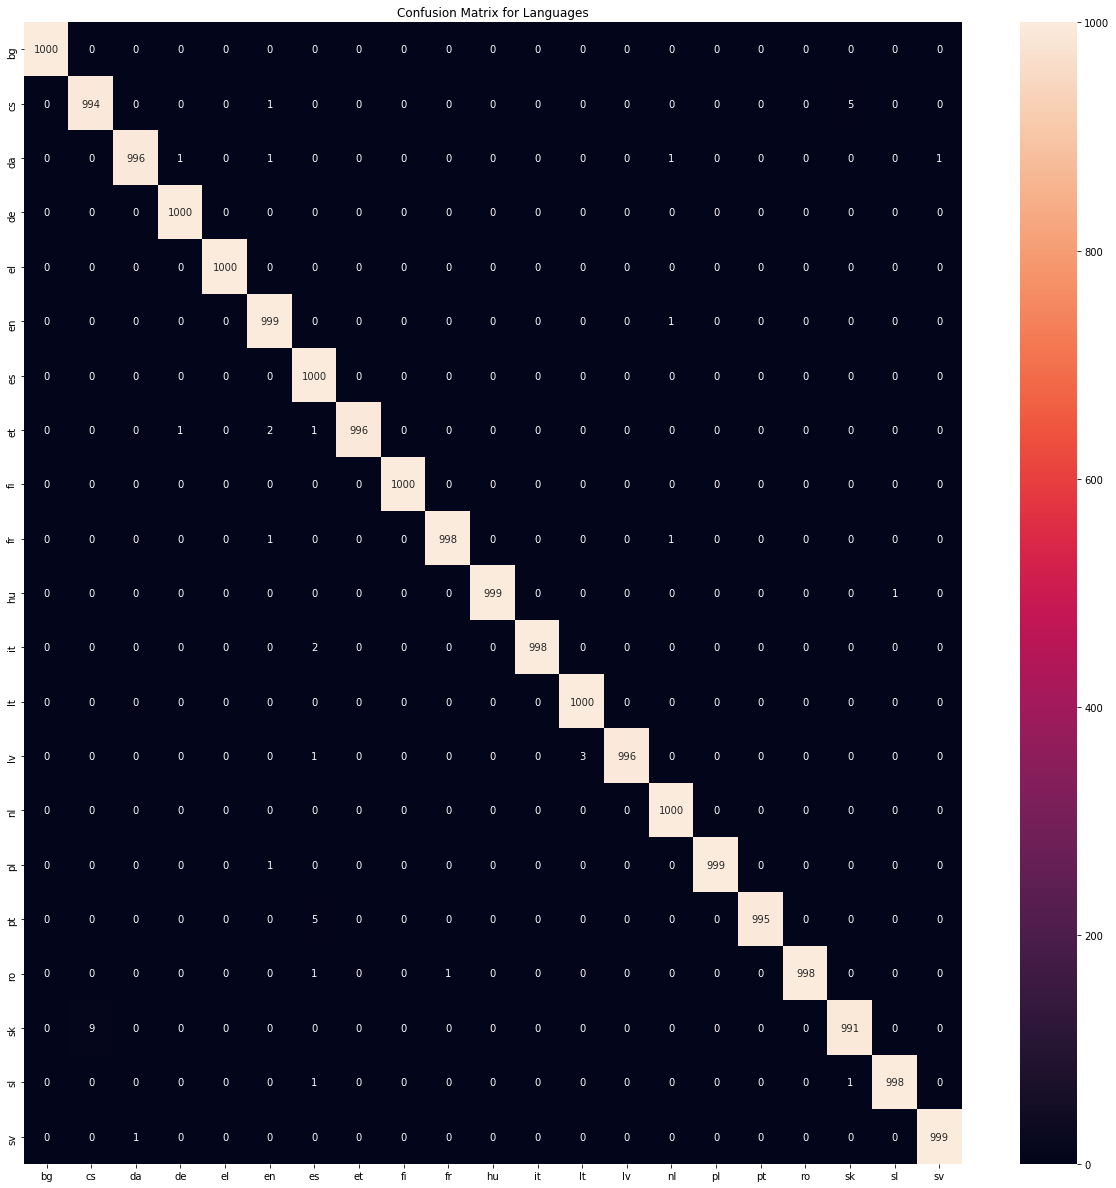

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(21, 21))
sns.heatmap(cm, annot=True,  fmt='', xticklabels=langs_arr, yticklabels=langs_arr);
plt.title('Confusion Matrix for Languages');